In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import pymatreader as reader
import matplotlib.pyplot as plt 

%matplotlib inline 

In [2]:
sns.set_style('whitegrid')

In [3]:
data = reader.read_mat('P5d.mat')

In [4]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Mar  1 22:25:31 2019',
 '__version__': '1.0',
 '__globals__': [],
 'Xtest': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'Xtrain': array([0.38344152, 0.4236548 , 0.43758721, 0.54488318, 0.5488135 ,
        0.60276338, 0.64589411, 0.71518937, 0.891773  , 0.96366276,
        0.1       , 0.5       , 0.9       ]),
 'y': array([ 2.05860808,  1.87620452,  1.94321898,  2.515363  ,  1.66866307,
         1.79265605,  1.81200662,  2.76299858,  3.06170275,  3.29733767,
        -5.        , -5.        , -5.        ])}

In [5]:
Xtrain, Xtest, y = data['Xtrain'], data['Xtest'], data['y']

<AxesSubplot:>

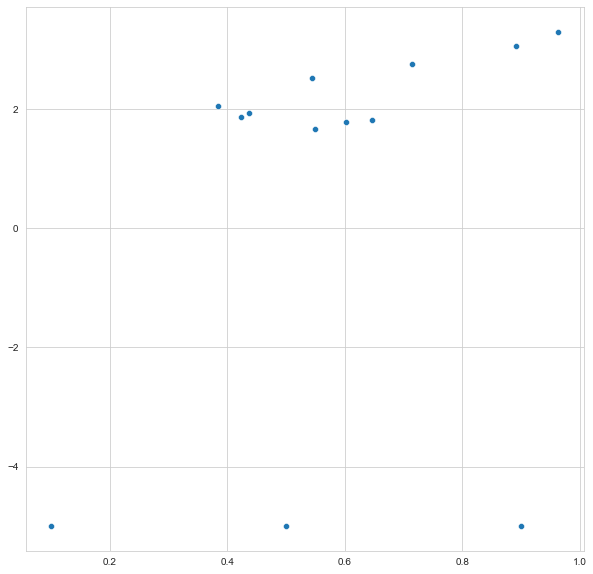

In [6]:
plt.figure(figsize=(10,10))
sns.scatterplot(x= Xtrain, y=y)

the student T regression model is a robust regression model, this is due to the fact that it has heavy tails unlike the normal distribution ! to implement a student T regression model we will use the gaussian linear models of pymc3 

In [7]:
import pymc3 as pm 

In [9]:
with pm.Model() as model:
    w0 = pm.Uniform('w0', -100, 100)
    w1 = pm.Uniform('w1', -100, 100)
    nu = pm.Uniform('nu', 1, 100)
    
    y_hat = w0 + w1 * Xtrain
    
    preds = pm.StudentT('preds', nu=nu, mu = y_hat, observed = y)

In [10]:
with model:
    step = pm.NUTS()
    trace_ = pm.sample(3000, step)
    
burn = 1000
thin = 2
trace = trace_[burn::thin]

<ipython-input-10-689e16dc5564>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_ = pm.sample(3000, step)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, w1, w0]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [11]:
w0 = trace['w0'].mean()
w1 = trace['w1'].mean()

In [12]:
w0

0.32159450837027836

In [13]:
w1

2.977185093358439

In [14]:
nu = trace['nu'].mean()

In [15]:
nu

1.704232760822054

In [16]:
predictions = w0 + (w1*Xtest)

In [17]:
predictions

array([0.32159451, 0.61931302, 0.91703153, 1.21475004, 1.51246855,
       1.81018706, 2.10790556, 2.40562407, 2.70334258, 3.00106109,
       3.2987796 ])

In [18]:
df = dict(x=Xtrain, y=y)

with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula("y ~ x", df, family=family)
    trace_robust = pm.sample(2000, cores=2)

<ipython-input-18-d3c191aeee45>:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_robust = pm.sample(2000, cores=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/adityagarg/opt/anaconda3/lib/python3.8/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


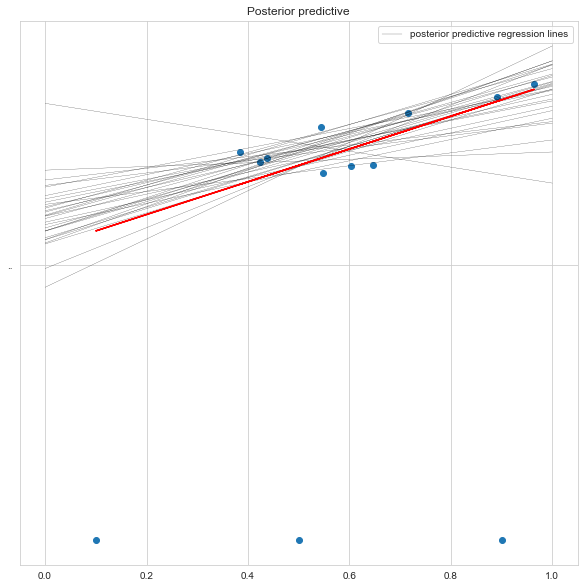

In [19]:
plt.figure(figsize=(10, 10))
plt.plot(Xtrain, y, "o")
pm.plot_posterior_predictive_glm(trace_robust, label="posterior predictive regression lines")
plt.plot(Xtrain, w0 + w1*Xtrain, 'r', '..')
plt.legend()

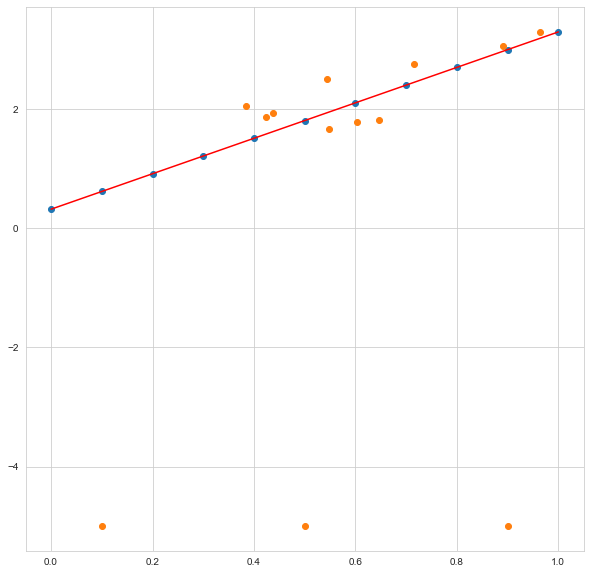

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(Xtest, predictions)
plt.scatter(Xtrain, y)
plt.plot(Xtest, predictions, 'r')